In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
import torch.nn as nn

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'dnn_fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = root_dir+"output/S%02d/%s_%s/" % (subject,model_name,timestamp) 
video_dir  = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-24-2021_1127


# Load stimuli

In [6]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [28]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


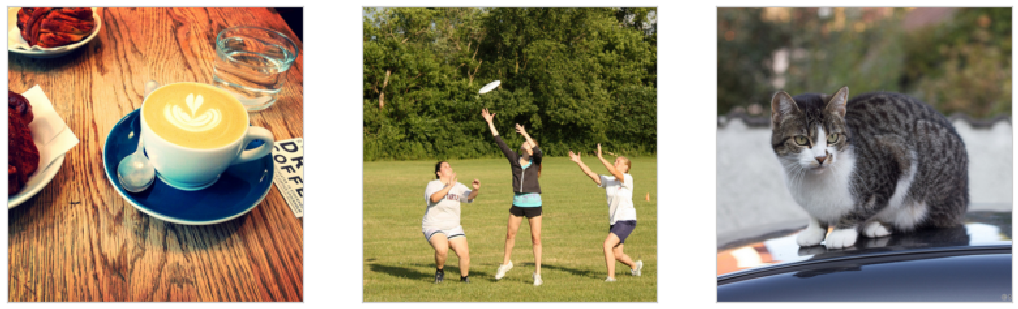

In [10]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [11]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [16]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subject)
voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%subject)
###
brain_nii_shape = voxel_roi_full.shape
print (brain_nii_shape)
###
voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
###
voxel_mask  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
voxel_idx   = np.arange(len(voxel_mask))[voxel_mask]
voxel_roi   = voxel_joined_roi_full[voxel_mask]
voxel_ncsnr = ncsnr_full.flatten()[voxel_mask]
        
print ('full mask length = %d'%len(voxel_mask))
print ('selection length = %d'%np.sum(voxel_mask))
    
for roi_mask, roi_name in iterate_roi(group, voxel_roi, roi_map, group_name=group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

(81, 104, 83)
full mask length = 699192
selection length = 238508
2396 	: V1
2071 	: V2
1667 	: V3
712 	: hV4
945 	: V3ab
474 	: LO
2148 	: IPS
480 	: VO
374 	: PHC
281 	: MT
54 	: MST
95498 	: other


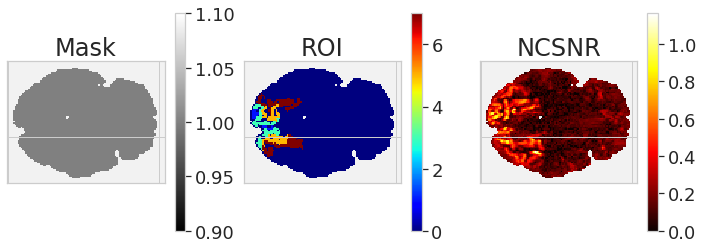

In [19]:
slice_idx = 35
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=output_dir+"subj%02d_mask"%subject)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"subj%02d_roi"%subject)
volume_ncsnr      = view_data(brain_nii_shape, voxel_idx, voxel_ncsnr, save_to=output_dir+"subj%02d_ncsnr"%subject) 
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
plt.title('NCSNR')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [20]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=4, load_ext=".mat")
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.113, <sigma> = 0.225
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.090, <sigma> = 0.200
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.117, <sigma> = 0.216
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.089, <sigma> = 0.190
(3000, 238508)


## Training/validation data split

In [21]:
from src.load_nsd import image_feature_fn, data_split

data_size, nv = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_feature_fn(image_data), voxel_data, ordering, imagewise=False)

Total number of voxels = 238508


In [23]:
del voxel_data

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [26]:
from src.torch_fwrf import get_value, set_value
from models.alexnet import Alexnet_fmaps
_fmaps_fn = Alexnet_fmaps().to(device)

_x = torch.tensor(trn_stim_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


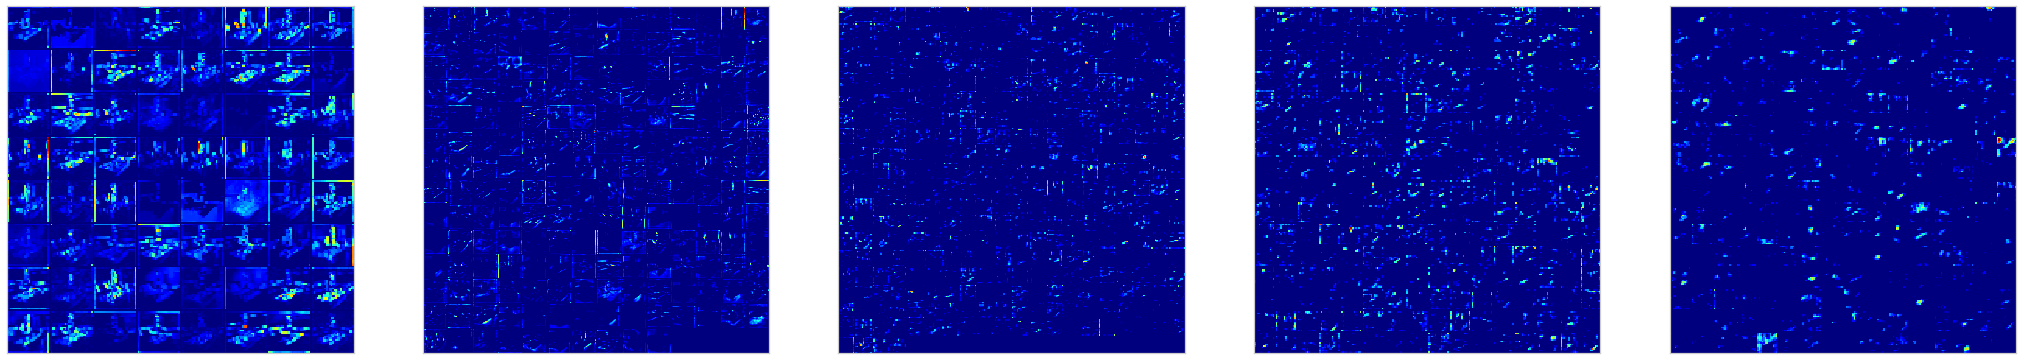

In [27]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:5]):
    plt.subplot(1,5,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [29]:
from src.torch_feature_space import filter_dnn_feature_maps

# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(image_data, _fmaps_fn, batch_size=100, fmap_max=512)

100it [00:08, 12.29it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)

fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


In [30]:
_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])


In [31]:
from PIL import Image
from matplotlib.patches import Patch
im_frame = Image.open(root_dir + 'J4_r_alpha_2D.png')
cmap = np.array(im_frame.getdata()).reshape((256,256,4))[:10]

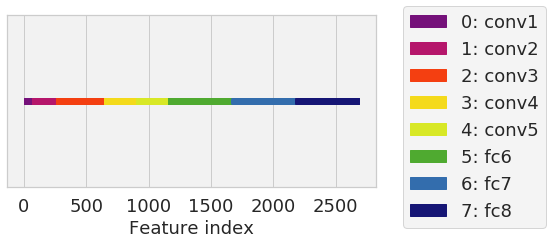

In [32]:
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
fig=plt.figure(figsize=(8, 4))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255), edgecolor=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255), label='%d: %s'%(k, layer_names[k])) for k,tm in enumerate(tuning_masks)]
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255))
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [34]:
filename = output_dir + "layer_feature_map%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [35]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 11
smin, smax = np.float32(0.04), np.float32(0.4)
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
#model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
#models = model_space(model_specs)
models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
print ('candidate count = ', len(models))

lambdas = np.logspace(3.,7.,9, dtype=np.float32)
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))

candidate count =  875


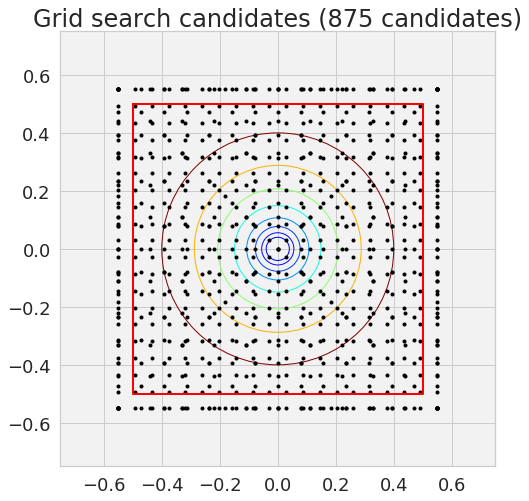

In [37]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

fig=plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

In [38]:
filename = output_dir + "rf_grid%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

In [40]:
from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block

sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 500

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

trn_size = 2217 (81.6%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  874 of 875 , voxels [238500:238507] of 238508
---------------------------------------
total time = 8882.249788s
total throughput = 0.037241s/voxel
voxel throughput = 0.032719s/voxel
setup throughput = 1.232551s/model


In [41]:
print ([p.shape if p is not None else None for p in best_params])

[(238508, 3), (238508, 2688), (238508,), (238508, 2688), (238508, 2688)]


In [44]:
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=image_data.shape, aperture=1.0)

voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

samples [  200:282  ] of 283, voxels [238500:238507] of 238508
---------------------------------------
total time = 545.763480s
sample throughput = 1.928493s/sample
voxel throughput = 0.002288s/voxel


In [45]:
#val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

 50%|█████     | 120442/238508 [00:12<00:11, 9887.67it/s]/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
100%|██████████| 238508/238508 [00:24<00:00, 9840.56it/s]


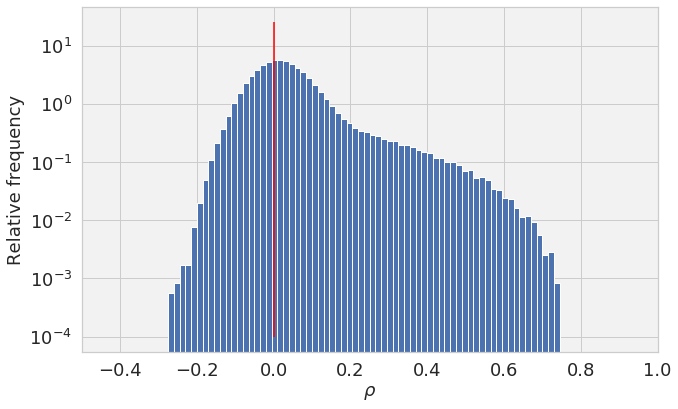

In [46]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

In [47]:
best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

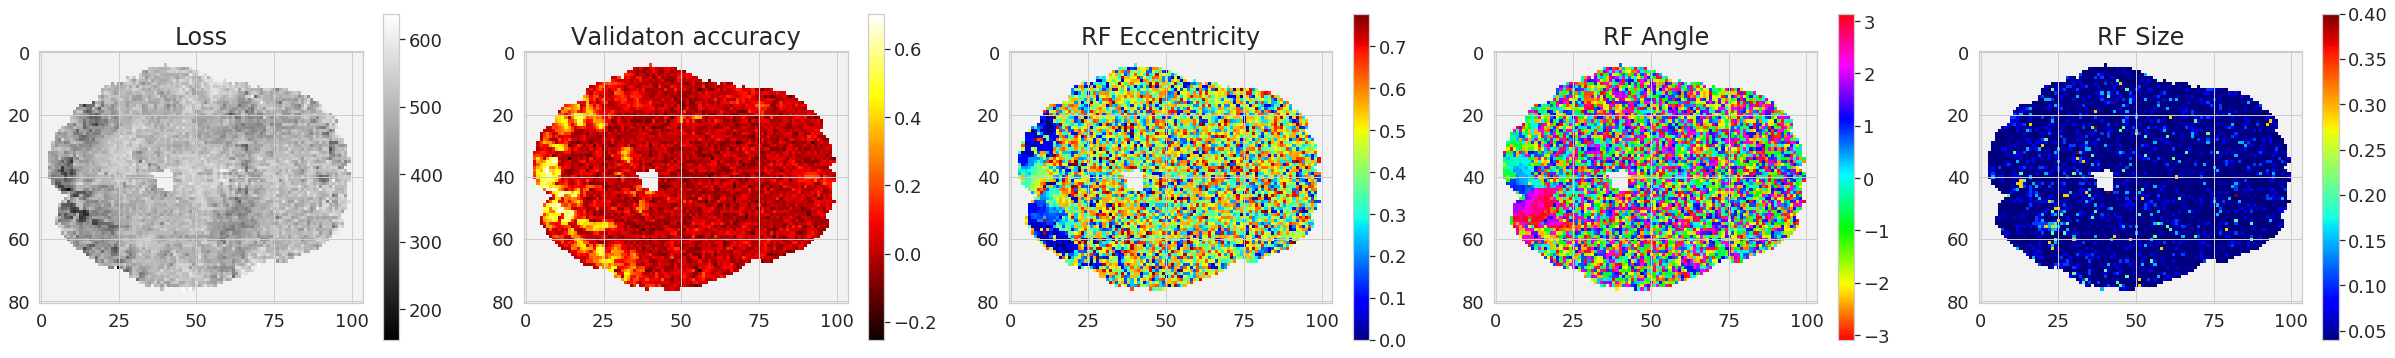

In [48]:
volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(42,6))
plt.subplot(1,5,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(1,5,2)
plt.title('Validaton accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(1,5,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(1,5,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(1,5,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

# Save results to disk

In [52]:
torch.save({
        'lmask': lmask,
        'fmask': fmask,
        'tuning_masks': tuning_masks,
        'aperture': aperture,
        'voxel_mask': voxel_mask,
        'brain_nii_shape': np.array(brain_nii_shape),
        'val_size': len(val_voxel_single_trial_data),
        'trn_size': len(trn_voxel_data),
        'ordering': ordering,
        'voxel_index': voxel_idx,
        'voxel_roi': voxel_roi,
        'params': best_params,
        'lambdas': lambdas, 
        'best_lambdas': best_lambdas,
        'val_cc': val_cc,
    }, output_dir+'model_params')

Feb-24-2021_1127
saved lmask@0 in h5py file
saved lmask@1 in h5py file
saved lmask@2 in h5py file
saved fmask@0 in h5py file
saved fmask@1 in h5py file
saved fmask@2 in h5py file
saved tuning_masks@0 in h5py file
saved tuning_masks@1 in h5py file
saved tuning_masks@2 in h5py file
saved tuning_masks@3 in h5py file
saved tuning_masks@4 in h5py file
saved tuning_masks@5 in h5py file
saved tuning_masks@6 in h5py file
saved tuning_masks@7 in h5py file
saved aperture in h5py file
saved voxel_mask in h5py file
saved brain_nii_shape in h5py file
saved val_size in h5py file
saved trn_size in h5py file
saved ordering in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved params@0 in h5py file
saved params@1 in h5py file
saved params@2 in h5py file
failed to save params@3 as h5py. will try pickle
failed to save params@4 as h5py. will try pickle
saved lambdas in h5py file
saved best_lambdas in h5py file
saved val_cc in h5py file
failed to save params@3 in any format. lost.


---

# Training sample scaling

# Compare validation accuracy value to previous method

In [38]:
pre_cc_volume  = load_mask_from_nii(root_dir+"output/S%02d/%s_%s/val_cc.nii" % (subject, 'dnn_fwrf', 'Mar-27-2020_0301'))
pre_cc = pre_cc_volume.flatten()[voxel_mask]

<Figure size 576x576 with 0 Axes>

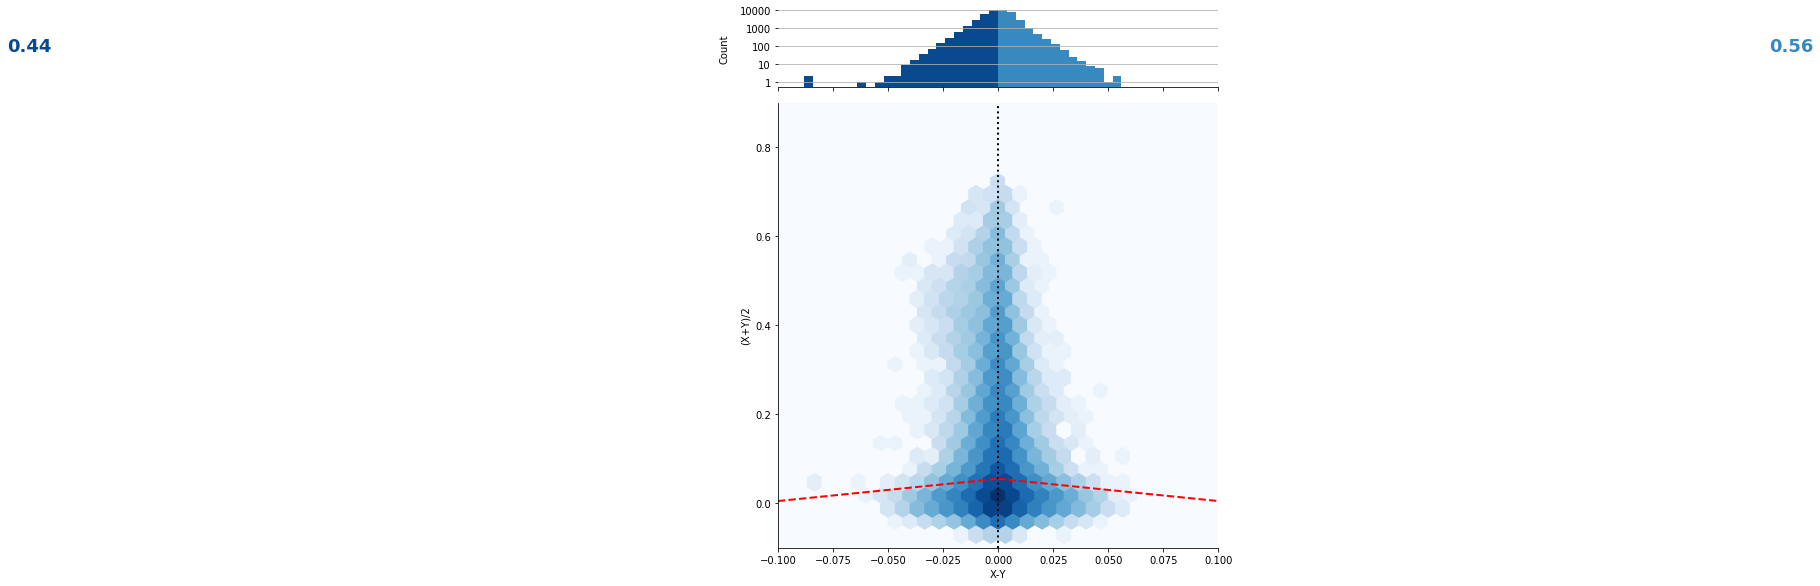

In [40]:
from src.plots import plot_fwrf_paper_compare

fig=plt.figure(figsize=(8, 8))
_=plot_fwrf_paper_compare(pre_cc, val_cc, 0.055, [-.1, .1], [-.1, .9])

In [26]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000
holdout_perc = .2
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print (trn_sizes)

[ 1000  2000  3000  6000  9000 18000 27000]


In [31]:
characteristics = {'trn_sizes': trn_sizes,
                  'ho_sizes': ho_sizes,
                  'voxel_index': voxel_idx,
                  'voxel_roi': voxel_roi,
                  'lambdas': lambdas}
###
for k,(ts,hs) in enumerate(zip(trn_sizes, ho_sizes)):  
    # training    
    best_losses, best_lambdas, best_params = learn_params_ridge_regression(
        trn_stim_data[:ts], trn_voxel_data[:ts], _fmaps_fn, models, lambdas, \
        aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
        voxel_batch_size=voxel_batch_size, holdout_size=hs, shuffle=False, add_bias=True)
    # validation    
    param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
    _fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_space=227, aperture=1.0)
    val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)    
    # prediction accuracy
    val_cc = np.zeros(shape=(nv,), dtype=fpX)    
    for v in tqdm(range(nv)):    
        val_cc[v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_single_trial_data[:,v])[0,1]
    # null threshold  
    null_val_cc = np.zeros(shape=(10, nv), dtype=fpX)
    for i in range(10):
        shuff = np.arange(len(val_voxel_pred))
        np.random.shuffle(shuff)
        shuffled_val_pred = val_voxel_pred[shuff]
        for v in tqdm(range(nv)):    
            null_val_cc[i,v] = np.corrcoef(shuffled_val_pred[:,v], val_voxel_single_trial_data[:,v])[0,1]
    cc_mn = np.mean(null_val_cc.flatten())
    cc_th = 3* np.std(null_val_cc.flatten())
    # save results 
    characteristics['result%d'%k] = {'trn_size': ts,
                          'best_lambdas': best_lambdas,
                          'cc_mn':        cc_mn,
                          'cc_th':        cc_th,
                          'val_cc':       val_cc}
    # print a summary
    print ('================================================')
    print ('median cc = %.3f, max cc = %.3f' % (np.median(val_cc), np.max(val_cc)))
    print ('================================================')
#################################################################    
characteristics['max_trn_size'] = trn_size
characteristics['val_size'] = val_size
## cc_threshold patch
cc_mns, cc_ths = [],[]
for i,ts in enumerate(characteristics['trn_sizes']):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]  
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
print ("cc th = (%.3f, %.3f)" % (cc_mn, cc_th))
characteristics['cc_mn'] = cc_mn
characteristics['cc_th'] = cc_th

trn_size = 800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 669.819758s
total throughput = 0.042773s/voxel
voxel throughput = 0.015491s/voxel
setup throughput = 0.588469s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 552/15660 [00:00<00:02, 5518.87it/s]


---------------------------------------
total time = 673.291628s
sample throughput = 0.224431s/sample
voxel throughput = 0.042994s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 6940.57it/s]


median cc = 0.155, max cc = 0.697
trn_size = 1600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 983.663992s
total throughput = 0.062814s/voxel
voxel throughput = 0.020027s/voxel
setup throughput = 0.922931s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5642.16it/s]


---------------------------------------
total time = 645.753095s
sample throughput = 0.215251s/sample
voxel throughput = 0.041236s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 6897.07it/s]


median cc = 0.185, max cc = 0.707
trn_size = 2400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 1228.225548s
total throughput = 0.078431s/voxel
voxel throughput = 0.024156s/voxel
setup throughput = 1.170729s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  3%|▎         | 537/15660 [00:00<00:02, 5363.80it/s]


---------------------------------------
total time = 636.530227s
sample throughput = 0.212177s/sample
voxel throughput = 0.040647s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7059.75it/s]


median cc = 0.199, max cc = 0.710
trn_size = 4800 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 2334.165585s
total throughput = 0.149053s/voxel
voxel throughput = 0.042394s/voxel
setup throughput = 2.300664s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 560/15660 [00:00<00:02, 5592.67it/s]


---------------------------------------
total time = 615.397670s
sample throughput = 0.205133s/sample
voxel throughput = 0.039297s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7022.46it/s]


median cc = 0.215, max cc = 0.721
trn_size = 7200 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 3233.486409s
total throughput = 0.206481s/voxel
voxel throughput = 0.057213s/voxel
setup throughput = 3.219746s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5640.67it/s]


---------------------------------------
total time = 530.243497s
sample throughput = 0.176748s/sample
voxel throughput = 0.033860s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7195.65it/s]


median cc = 0.223, max cc = 0.724
trn_size = 14400 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 5283.283254s
total throughput = 0.337374s/voxel
voxel throughput = 0.100990s/voxel
setup throughput = 5.098865s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 565/15660 [00:00<00:02, 5649.92it/s]


---------------------------------------
total time = 485.605738s
sample throughput = 0.161869s/sample
voxel throughput = 0.031009s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7060.83it/s]


median cc = 0.233, max cc = 0.732
trn_size = 21600 (80.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  725 of 726 , voxels [ 15500:15659 ] of 15660
---------------------------------------
total time = 8835.875487s
total throughput = 0.564232s/voxel
voxel throughput = 0.215589s/voxel
setup throughput = 7.520317s/model
samples [ 2800:2999 ] of 3000, voxels [ 15500:15659 ] of 15660

  4%|▎         | 571/15660 [00:00<00:02, 5702.15it/s]


---------------------------------------
total time = 458.248451s
sample throughput = 0.152749s/sample
voxel throughput = 0.029262s/voxel


100%|██████████| 15660/15660 [00:02<00:00, 7208.22it/s]

median cc = 0.237, max cc = 0.736
cc th = (-0.000, 0.055)


## Save scaling data

In [32]:
param_file_name = "dnn_fwrf_%s_scaling" % (timestamp)
print (param_file_name)

save_stuff(output_dir + param_file_name, flatten_dict(characteristics))

dnn_fwrf_Apr-06-2020_2050_scaling
saved trn_sizes in h5py file
saved ho_sizes in h5py file
saved voxel_index in h5py file
saved voxel_roi in h5py file
saved lambdas in h5py file
saved result0.trn_size in h5py file
saved result0.best_lambdas in h5py file
saved result0.cc_mn in h5py file
saved result0.cc_th in h5py file
saved result0.val_cc in h5py file
saved result1.trn_size in h5py file
saved result1.best_lambdas in h5py file
saved result1.cc_mn in h5py file
saved result1.cc_th in h5py file
saved result1.val_cc in h5py file
saved result2.trn_size in h5py file
saved result2.best_lambdas in h5py file
saved result2.cc_mn in h5py file
saved result2.cc_th in h5py file
saved result2.val_cc in h5py file
saved result3.trn_size in h5py file
saved result3.best_lambdas in h5py file
saved result3.cc_mn in h5py file
saved result3.cc_th in h5py file
saved result3.val_cc in h5py file
saved result4.trn_size in h5py file
saved result4.best_lambdas in h5py file
saved result4.cc_mn in h5py file
saved res

## Figures

Text(0, 0.5, 'Count')

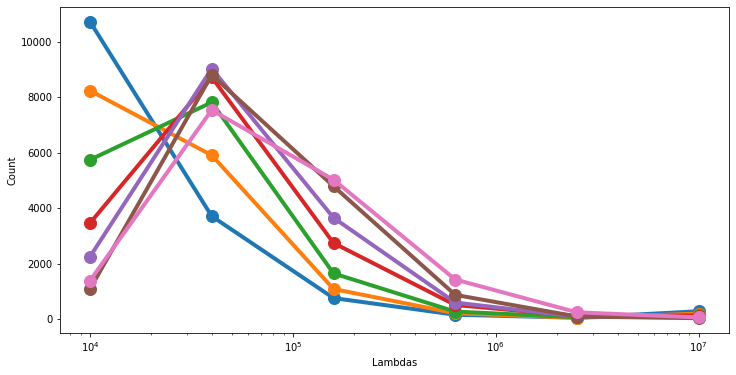

In [34]:
fig=plt.figure(figsize=(12,6))
for i,ts in enumerate(trn_sizes):
    plt.plot(lambdas, [np.sum(characteristics['result%d'%i]['best_lambdas']==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

In [35]:
result_cc, cc_ths, cc_mns, median_cc, top_cc, count_cc = [],[],[],[],[],[]
for i,ts in enumerate(trn_sizes):
    cc_mns += [characteristics['result%d'%i]['cc_mn'],]
    cc_ths += [characteristics['result%d'%i]['cc_th'],]
    result_cc += [characteristics['result%d'%i]['val_cc'],]
    median_cc += [np.median(characteristics['result%d'%i]['val_cc'])]
    top_cc += [np.max(characteristics['result%d'%i]['val_cc'])]
cc_mn = np.mean(cc_mns)    
cc_th = np.mean(cc_ths)
for i,ts in enumerate(trn_sizes):
    count_cc += [np.sum(characteristics['result%d'%i]['val_cc']>(cc_mn+cc_th))]

Text(0, 0.5, 'Above threshold')

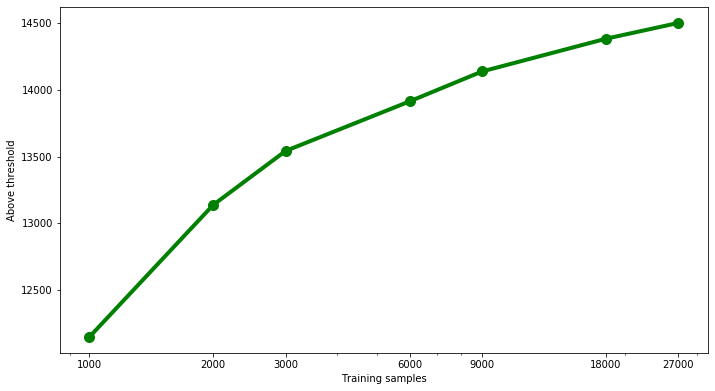

In [50]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
plt.plot([min(trn_size,s) for s in trn_sizes], count_cc, marker='o', ms=10, color='g', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Above threshold')

In [52]:
filename = output_dir + "validation_above_threshold_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

Text(0, 0.5, 'Validation accuracies')

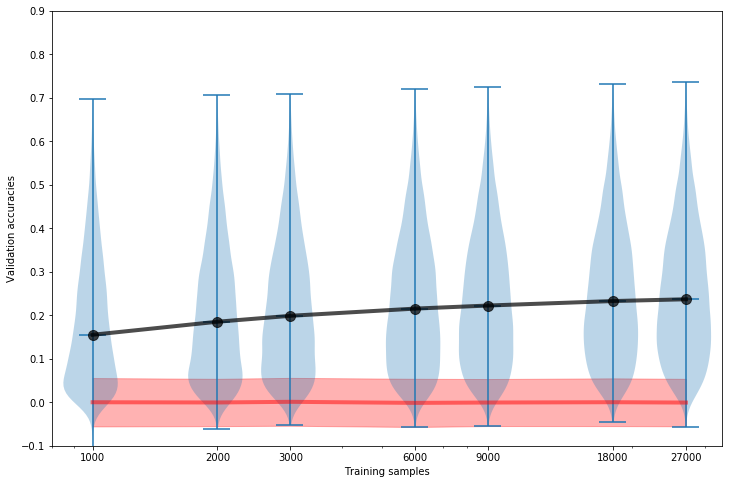

In [53]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot([min(trn_size,s) for s in trn_sizes], cc_mns, color='r', lw=4, alpha=.5)
plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
plt.violinplot(result_cc, positions=[min(trn_size,s) for s in trn_sizes], widths=np.array([min(trn_size,s) for s in trn_sizes])*.3, showmedians=True)
plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')